<a href="https://colab.research.google.com/github/giardinas-dev/ml-traditional-sklearn/blob/main/mercato_immobiliare_ml_fondamenti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,PolynomialFeatures,OneHotEncoder
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import KFold,cross_validate,learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

RANDOMSEED = 2

In [ ]:
from math import sqrt
# Funzione per valutare le performance di un modello su un dataset
def evaluate(model, dataset_x, dataset_y):
  y = dataset_y
  y_pred = model.predict(dataset_x)
  coefs = model.coef_
  threshold = 1e-3  # Soglia arbitraria
  num_almost_zero = np.sum(np.abs(coefs) < threshold)
  return sqrt(mean_squared_error(y,y_pred)),r2_score(y,y_pred),num_almost_zero,len(coefs),y_pred



In [ ]:
# Funzione che addestra il modello e valuta sia sul train che sul test set
def fit_and_evaluate(model,train,test):
  x_train ,y_train = train
  model.fit(x_train ,y_train)
  rmse, r2, numzero, coef_len, y_pred = evaluate(model,x_train,y_train)
  train = {'rmse':rmse,'r2':r2,'zerocoef':numzero,'coef_len':coef_len}
  x_test,y_test = test
  rmse, r2, numzero, coef_len,y_pred = evaluate(model,x_test,y_test)
  test = {'rmse':rmse,'r2':r2,'zerocoef':numzero,'coef_len':coef_len,'y_pred':y_pred}
  return train,test


In [ ]:
# Funzione che esegue cross-validation e restituisce le medie dei punteggi R2 per train e test

# NB: la traformazione polinomiale sulle Feature è stata volutamente rimossa in tale modello
# in quanto i risultati mostravano un evidente overfitting in quanto l'R2 sul testset
# crollava enormemente (~ 0.5 ) a differenza del R2 del train set che risultava molto
# performante (~ 0.8 )

# Parte del codice di questa funzione è stato realizzato attraverso l'uso di Chat-GPT.
def cross_validation(model,x,y):



   preprocessor = ColumnTransformer([('ohe',OneHotEncoder(),[11])], remainder='passthrough')


   pipeline = make_pipeline(preprocessor, StandardScaler(), model )

   cv = KFold(n_splits=5, shuffle=True, random_state=RANDOMSEED)
   scores = cross_validate(
    pipeline, x, y,
    cv=cv,
    scoring='r2',
    return_train_score=True
)
   return  scores['train_score'].mean(),scores['test_score'].mean()


**STANDARDIZZAZIONE**

È stata applicata una standardizzazione a tutte le feature numeriche dopo la creazione delle feature polinomiali, tramite *StandardScaler*, al fine di garantire che tutte le feature abbiano pari importanza nella penalizzazione.

**TRASFORMAZIONE FEATURES**

È stata applicata una trasformazione polinomiale di grado 2 con *PolynomialFeatures*, che ha generato interazioni quadratiche e tra variabili.
Questo ha ampliato lo spazio delle feature da circa 12 iniziali a 91.
L'obiettivo era aumentare la complessità del modello e catturare relazioni non lineari.

**SCELTA DEI MODELLI**

Sono stati implementati e confrontati i seguenti modelli di regressione regolarizzata:

- Ridge Regression L2: regolarizzazione L2 sulla somma dei quadrati dei coefficienti.

- ElasticNet ( L1 + L2) : combinazione di regolarizzazione L1 ( sparsità ) e L2.

- Lasso L1: è stato inizialmente previsto ma disattivato per motivi di mancata convergenza del modello.

**CROSS VALIDATION E IPERPARAMETRI**


È stata effettuata una 5‑fold cross-validation su tutto il dataset (prima della trasformazione polinomiale), utilizzando R² come metrica di scoring.

Sono stati testati diversi valori di alpha (0.1, 1, 10, 50, 100, 150) per valutare l’impatto della regolarizzazione.

*ElasticNet* potrebbe diventare preferibile aumentando la sparsità (più coefficienti nulli) agendo su l1_ratio, ma con 1 solo coefficiente nullo su 91 non sembra offrire vantaggi evidenti.

È stato scelto come “modello migliore” quello con R² sul test set maggiore di 0.65 ** e una differenza tra training e test R² inferiore a 0.05, garantendo buone performance e stabilità.



*** risultato ricavato da vari test di tuning sui parametri quali alpha,feature,numero di interazioni e L1_ratio*.

In [ ]:
# Funzione principale per testare modelli di regressione regolarizzata


def test_models(train, test, x , y , features):
  train_x,train_y = train
  test_x,test_y = test

  # Feature polinomiali grado 2 ( aggiunge non linearità )

  poly = PolynomialFeatures(degree = 2)
  train_x = poly.fit_transform(train_x)
  test_x = poly.transform(test_x)

  # Standardizzazione delle feature ( media 0 , deviazione standard 1 )
  ss = StandardScaler()
  train_x = ss.fit_transform(train_x)
  test_x = ss.transform(test_x)

  # Analizziamo valori di alpha > 0.1 cosi da garantire una regolarizzazione forte
  # utile nel caso di tante feature ( 91 in caso di trasformazione polinomiale )
  alpha = [0.1,1,10,50,100,150]

  best_model = []

  for a in alpha:
    r = Ridge(alpha =a,max_iter=10000) #Ridge regression ( L2 )
    #l = Lasso(alpha= a,max_iter=5000) # disabilitato perchè non converge anche con num interazioni alto
    e = ElasticNet(alpha=a,max_iter=10000,l1_ratio = 0.4) # Elastic Net combinazione L1-L2

    models = {
      "RIDGE":r,
      "ELASTICNET":e
    }


    for k in models.keys():

      # Valutazione tramite cross-validation (su tutto x, y)
      train_score, test_score = cross_validation(models[k],x,y)
      # Fit e valutazione sui set train/test
      train_result ,test_result = fit_and_evaluate(models[k],(train_x,train_y),(test_x,test_y))

      # Stampa risultati solo se R2 è sopra soglia ( buona performance )

      if test_result['r2'] > 0.60 and train_result['r2'] > 0.70:

        # Recupero feature con relativi coefficenti
        feature_names = poly.get_feature_names_out(input_features=features)
        coefs = models[k].coef_
        importances = pd.Series(coefs, index=feature_names)

        print(f"MODELLO:{k} LAMBDA:{str(a)}")
        print("CROSS VALIDATION")
        print(f"TRAIN R2:{train_score:.3f}")
        print(f"TEST  R2:{test_score:.3f}")
        print("TRAINSET")
        print(f" RMSE:{train_result['rmse']:.2f}")
        print(f" R2:{train_result['r2']:.3f}")
        print(f" COEF NULL:{train_result['zerocoef']} su {train_result['coef_len']}")
        print("TESTSET")
        print(f" RMSE:{test_result['rmse']:.2f}")
        print(f" R2:{test_result['r2']:.3f}")
        print(f" COEF NULL:{test_result['zerocoef']} su {test_result['coef_len']}")
        print("\n\n")

        # Tieni i migliori modelli per analisi performance
        if test_result['r2'] > 0.65 and train_result['r2']-test_result['r2']<0.1:
          best_model.append({'name':k,'alpha':str(a),'model':models[k],'train':train_result,
                              'test':test_result,'importances':importances})

  return best_model





- È stata generata la curva di apprendimento (*learning curve*) per ogni modello, permettendo di valutare se la performance migliora all’aumentare dei dati, utile per decidere se è necessario raccogliere più dati.

- È stato realizzato un plot residui vs predetti per controllare se ci sono pattern sistematici negli errori (es. eteroschedasticità o bias non modellati)

- È stato realizzato anche un bar-plot relativo al peso delle varie feature sul target.

NB: Il codice relativo ai plot è stato realizzato attraverso l'uso di Chat-GPT.

In [ ]:
# Funzione per visualizzare la curva di apprendimento (learning curve)
def showLearning_curve(title,model,x,y):
  sns.set_theme()
  train_size_abs, train_scores, test_scores = learning_curve(
      model,
      x,
      y,
      random_state=RANDOMSEED
  )

  plt.plot(train_size_abs,train_scores.mean(axis=1),label="Train scores")
  plt.plot(train_size_abs,test_scores.mean(axis=1),label="Test scores")
  plt.legend()
  plt.title(title)
  plt.show()


In [ ]:

from matplotlib.ticker import FuncFormatter
# Funzione per visualizzare residui vs valori predetti, permette di valutare l'adeguatezza del modello
def residuals_vs_predicted(title, model, y_test, y_preds):
  residuals = y_test - y_preds

  plt.figure(figsize=(10,6))
  sns.residplot(x= y_preds, y=residuals,lowess=True, scatter_kws={'alpha':0.5},line_kws={'color':'orange','lw':1})

  # Permette di comprendere meglio il valore del target predetto
  formatter = FuncFormatter(lambda x, _: f'{x*1e-6:.1f}M')
  plt.gca().xaxis.set_major_formatter(formatter)
  plt.gca().yaxis.set_major_formatter(formatter)
  # Centra i dati
  plt.xlim(2_000_000, 8_000_000)
  plt.title("")
  plt.xlabel("Valori predetti")
  plt.ylabel("Residui (Valore vero - Valori predetti)")
  plt.axhline(0,color="black",linestyle="--")
  plt.tight_layout()
  plt.show()

In [ ]:
def plot_top_features(importances,title):
  features = importances.abs().sort_values(ascending=False).head(10)
  indices = features.index
  values = importances[indices]

  plt.figure(figsize=(10, 6))
  bars = plt.barh(indices, values, color=['green' if x > 0 else 'red' for x in values])

  plt.xlabel('Valore coefficiente')
  plt.title(title)
  plt.gca().invert_yaxis()  # La feature più importante in alto

    # Aggiunge le etichette numeriche vicino alle barre
  for bar in bars:
      width = bar.get_width()
      plt.text(width + (0.01 * np.sign(width)), bar.get_y() + bar.get_height() / 2,
                 f'{width:.0f}', va='center')

  plt.tight_layout()
  plt.show()



In [ ]:

source_csv = 'https://proai-datasets.s3.eu-west-3.amazonaws.com/housing.csv'

df = pd.read_csv(source_csv)

# Test per un ulteriore sorting del dataset in quanto ordinato per price,
# ma risulta ininfluente sui risultati del modello
#df = df.sample(frac=1, random_state=42)

df.head()



,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,2
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1


**Gestione dei Valori Mancanti**

È stata effettuata una verifica dei valori nulli tramite *df.isna().sum()* e *df.info()*.
Non sono stati rilevati valori mancanti, quindi non è stato necessario effettuare operazioni di imputazione o rimozione.

**Separazione del Target**

La variabile target **price** è stata correttamente separata dal dataset.

**Label Encoding**

Le variabili binarie come mainroad, basement, airconditioning, ecc. erano già in formato numerico (0/1), quindi non è stato necessario codificarle ulteriormente.
La variabile *Furnishingstatus*, con valori 0, 1, 2, è stata trattata implicitamente come variabile ordinale.

In [ ]:
print(df.describe())
#stampiamo le informazioni generali sui valori possibili delle features


print(df.isna().sum())
#controlliamo che tutti i valori delle features non siano nulli nelle varie osservazioni

print(df.info())
#controlliamo il tipo delle features per capire eventuale label encoding per variabili qualitative


#togliamo la colonna target
x = df.drop('price',axis = 1).values


y = df['price'].values



              price          area    bedrooms   bathrooms     stories  \
count  5.450000e+02    545.000000  545.000000  545.000000  545.000000   
mean   4.766729e+06   5150.541284    2.965138    1.286239    1.805505   
std    1.870440e+06   2170.141023    0.738064    0.502470    0.867492   
min    1.750000e+06   1650.000000    1.000000    1.000000    1.000000   
25%    3.430000e+06   3600.000000    2.000000    1.000000    1.000000   
50%    4.340000e+06   4600.000000    3.000000    1.000000    2.000000   
75%    5.740000e+06   6360.000000    3.000000    2.000000    2.000000   
max    1.330000e+07  16200.000000    6.000000    4.000000    4.000000   

         mainroad   guestroom    basement  hotwaterheating  airconditioning  \
count  545.000000  545.000000  545.000000       545.000000       545.000000   
mean     0.858716    0.177982    0.350459         0.045872         0.315596   
std      0.348635    0.382849    0.477552         0.209399         0.465180   
min      0.000000    0.000

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state= RANDOMSEED)

# ONE HOT ENCODER IL FURNISHING SHATUS
ct = ColumnTransformer([
    ('ohe',OneHotEncoder(),[11]),],
    remainder = 'passthrough'
)
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)
features = ct.named_transformers_['ohe'].get_feature_names_out(['furnishingstatus'])
features = list(features) + list(df.drop(['price','furnishingstatus'],axis = 1))


models = test_models((X_train,y_train),(X_test,y_test),x,y,features)


MODELLO:ELASTICNET LAMBDA:0.1
CROSS VALIDATION
TRAIN R2:0.684
TEST  R2:0.658
TRAINSET
 RMSE:867166.43
 R2:0.780
 COEF NULL:4 su 120
TESTSET
 RMSE:1122488.47
 R2:0.657
 COEF NULL:4 su 120



MODELLO:ELASTICNET LAMBDA:1
CROSS VALIDATION
TRAIN R2:0.651
TEST  R2:0.634
TRAINSET
 RMSE:939969.72
 R2:0.741
 COEF NULL:4 su 120
TESTSET
 RMSE:1096577.48
 R2:0.673
 COEF NULL:4 su 120



MODELLO:RIDGE LAMBDA:10
CROSS VALIDATION
TRAIN R2:0.684
TEST  R2:0.657
TRAINSET
 RMSE:846435.02
 R2:0.790
 COEF NULL:4 su 120
TESTSET
 RMSE:1163831.77
 R2:0.631
 COEF NULL:4 su 120



MODELLO:RIDGE LAMBDA:50
CROSS VALIDATION
TRAIN R2:0.682
TEST  R2:0.658
TRAINSET
 RMSE:890223.91
 R2:0.768
 COEF NULL:4 su 120
TESTSET
 RMSE:1105311.63
 R2:0.668
 COEF NULL:4 su 120



MODELLO:RIDGE LAMBDA:100
CROSS VALIDATION
TRAIN R2:0.677
TEST  R2:0.655
TRAINSET
 RMSE:912345.09
 R2:0.756
 COEF NULL:4 su 120
TESTSET
 RMSE:1098263.05
 R2:0.672
 COEF NULL:4 su 120



MODELLO:RIDGE LAMBDA:150
CROSS VALIDATION
TRAIN R2:0.670
TEST  R2:0.6

[{'label': 'positive', 'count': 24, 'value_avg': 0.7417, 'text_length_avg': 22.46, 'timestamps': ['2025-08-06T14:19:56.679730', '2025-08-06T14:20:29.035628', '2025-08-06T14:21:09.341033', '2025-08-06T14:22:29.820338', '2025-08-06T14:23:10.138465', '2025-08-06T14:25:50.958024', '2025-08-06T14:29:12.398359', '2025-08-06T14:29:52.709010', '2025-08-06T14:31:13.344680', '2025-08-06T14:34:34.856666', '2025-08-06T14:35:15.159082', '2025-08-06T14:37:15.971211', '2025-08-06T14:38:36.285273', '2025-08-06T14:40:37.036514', '2025-08-06T14:48:39.842056', '2025-08-06T14:49:19.989783', '2025-08-06T14:50:40.472654', '2025-08-06T14:52:40.927291', '2025-08-06T14:53:21.233807', '2025-08-06T14:54:01.388730', '2025-08-06T14:55:21.697117', '2025-08-06T14:56:01.986411', '2025-08-06T14:56:42.150235', '2025-08-06T14:58:02.616281'], 'count_norm': 1.0, 'text_length_norm': 0.5510027100271006}, {'label': 'neutral', 'count': 16, 'value_avg': 0.6894, 'text_length_avg': 20.25, 'timestamps': ['2025-08-06T14:20:16.9962

/tmp/ipython-input-1279349989.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, order=['negative', 'neutral', 'positive'], palette=['red', 'gray', 'green'])


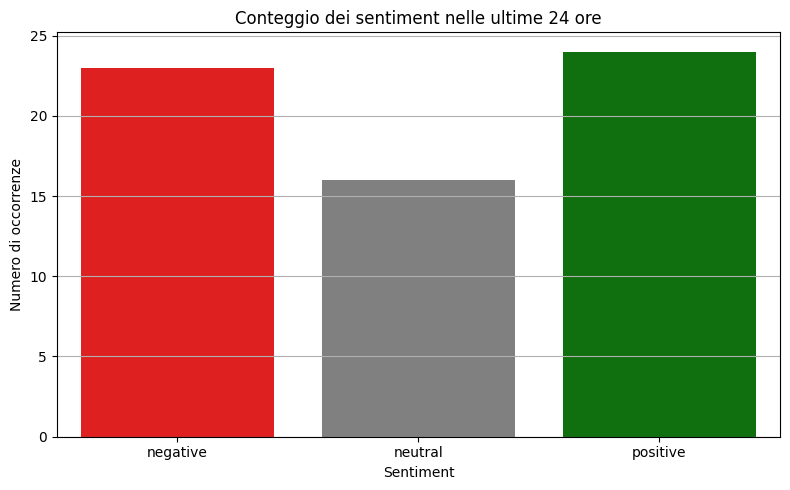

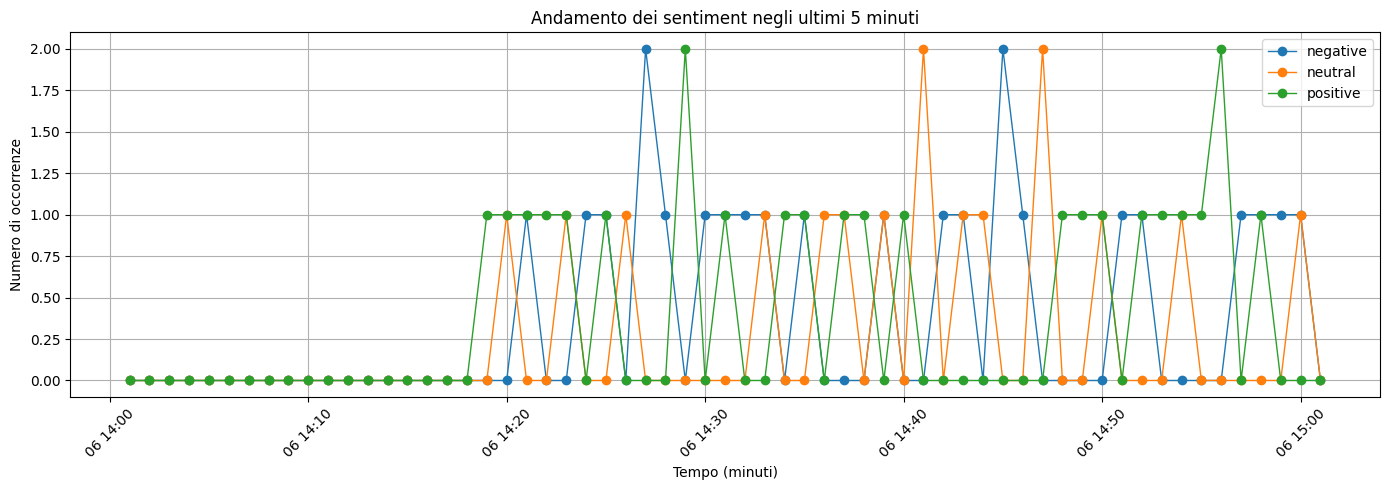

/tmp/ipython-input-1279349989.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='value_avg', data=df, palette=['red', 'gray', 'green'])
/tmp/ipython-input-1279349989.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='text_length_avg', data=df, palette=['red', 'gray', 'green'])


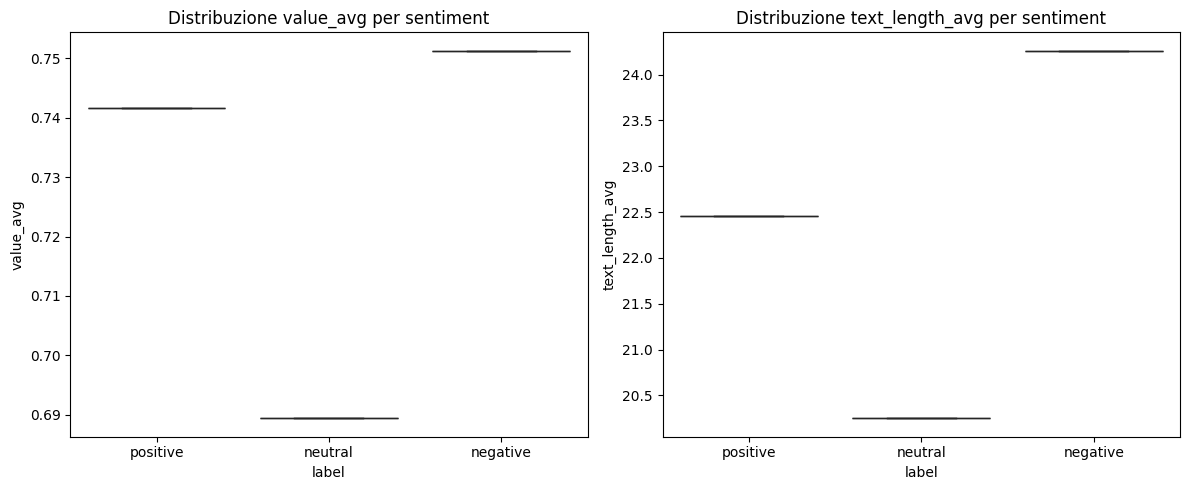

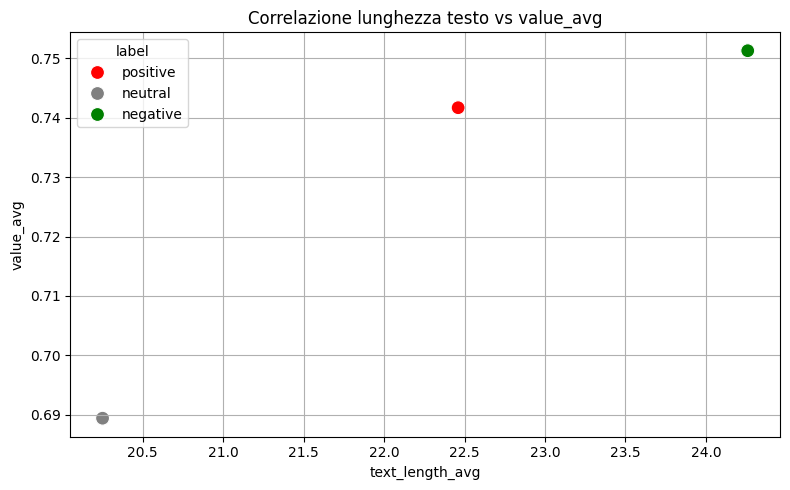

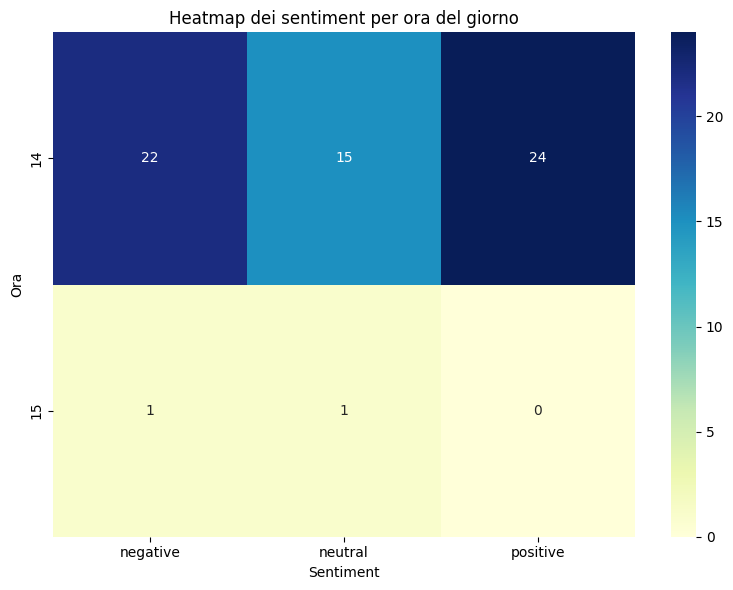

In [ ]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns

# === 1. Fetch data from API ===
url = "https://metrics-fastapi-sentiment-analysis.onrender.com/metrics_data"  # 🔁 Sostituisci con la tua URL reale
response = requests.get(url)
if response.status_code != 200:
    raise Exception(f"API call failed with status code {response.status_code}")
data = response.json()
print(data)

# === 2. Flatten data and convert timestamps ===
all_rows = []
for row in data:
    for ts in row["timestamps"]:
        all_rows.append({
            "label": row["label"],
            "timestamp": pd.to_datetime(ts),
            "value_avg": row["value_avg"],
            "text_length_avg": row["text_length_avg"]
        })

df = pd.DataFrame(all_rows)

# Filter last 24 hours
now = datetime.utcnow()
yesterday = now - timedelta(days=1)
df = df[df["timestamp"] >= yesterday]

# === 3. Statistics ===
# Percentuali di sentiment
sentiment_counts = df['label'].value_counts()
sentiment_percent = sentiment_counts / sentiment_counts.sum() * 100

# Media e deviazione standard dei valori
value_stats = df.groupby('label')['value_avg'].agg(['mean', 'std'])
length_stats = df.groupby('label')['text_length_avg'].agg(['mean', 'std'])

#print("Percentuale sentiment nelle ultime 24 ore:\n", sentiment_percent)
#print("\nStatistiche value_avg:\n", value_stats)
#print("\nStatistiche text_length_avg:\n", length_stats)

# === 4. Plot 1: Conteggio dei sentiment ===
plt.figure(figsize=(8,5))
sns.countplot(x='label', data=df, order=['negative', 'neutral', 'positive'], palette=['red', 'gray', 'green'])
plt.title("Conteggio dei sentiment nelle ultime 24 ore")
plt.ylabel("Numero di occorrenze")
plt.xlabel("Sentiment")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# === 5. Plot 2: Timeline sentiment per minuto (ultime 5 ore) ===

# Timestamp attuale arrotondato al minuto
now_ts = pd.Timestamp.now().floor('min')
five_hours_ago_ts = now_ts - pd.Timedelta(hours=1)

# Range di minuti per le ultime 5 ore
minutes_range = pd.date_range(start=five_hours_ago_ts, end=now_ts, freq='min')

# Arrotonda i timestamp del DataFrame al minuto
df['timestamp_minute'] = df['timestamp'].dt.floor('min')

# Filtro: solo dati delle ultime 5 ore
df_filtered = df[df['timestamp_minute'].between(five_hours_ago_ts, now_ts)]

# Plot
plt.figure(figsize=(14, 5))
for label in ['negative', 'neutral', 'positive']:
    df_label = df_filtered[df_filtered['label'] == label]
    df_minutely = df_label.groupby('timestamp_minute').size()
    df_minutely = df_minutely.reindex(minutes_range, fill_value=0)
    plt.plot(df_minutely.index, df_minutely.values, marker='o', label=label, linewidth=1)

plt.title("Andamento dei sentiment negli ultimi 5 minuti")
plt.xlabel("Tempo (minuti)")
plt.ylabel("Numero di occorrenze")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# === 6. Plot 3: Boxplot dei valori e lunghezze ===
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(x='label', y='value_avg', data=df, palette=['red', 'gray', 'green'])
plt.title("Distribuzione value_avg per sentiment")
plt.subplot(1,2,2)
sns.boxplot(x='label', y='text_length_avg', data=df, palette=['red', 'gray', 'green'])
plt.title("Distribuzione text_length_avg per sentiment")
plt.tight_layout()
plt.show()

# === 7. Plot 4: Scatter text length vs value_avg ===
plt.figure(figsize=(8,5))
sns.scatterplot(x='text_length_avg', y='value_avg', hue='label', data=df, palette=['red','gray','green'], s=100)
plt.title("Correlazione lunghezza testo vs value_avg")
plt.xlabel("text_length_avg")
plt.ylabel("value_avg")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 8. Heatmap: sentiment per ora ===
df['hour'] = df['timestamp'].dt.hour
heatmap_data = df.pivot_table(index='hour', columns='label', aggfunc='size', fill_value=0)
plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Heatmap dei sentiment per ora del giorno")
plt.ylabel("Ora")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.show()


Tutti i modelli selezionati mostrano R² sul test set intorno a 0.65–0.70, considerata una buona performance per un problema reale complesso.

Gli RMSE dell’ordine del milione sono in linea con l’ordine di grandezza dei prezzi immobiliari nel dataset.

La differenza contenuta tra train R² e test R² (< 0.05) indica un buon bilanciamento tra accuratezza e generalizzazione ( basso overfitting ).

**MODELLO:ELASTIC α:1**


- CROSS VALIDATION
-- TRAIN R2: 0.647
-- TEST  R2: 0.630
- TRAIN/TEST SPLIT EVALUATION
-- TRAIN SET
 -- RMSE: 969460.84
 -- R2: 0.724
 -- COEF NULL: 1 su 91
-- TEST SET
 -- RMSE: 1073367.74
 -- R2: 0.687
 -- COEF NULL: 1 su 91





**MODELLO:RIDGE α:100**
- CROSS VALIDATION
-- TRAIN R2: 0.674
-- TEST R2: 0.652

- TRAIN/TEST SPLIT EVALUATION
-- TRAIN SET
 -- RMSE: 944565.84
 -- R2: 0.738
 -- COEF NULL: 1 su 91
-- TEST SET
 -- RMSE: 1062584.40
 -- R2: 0.693
 -- COEF NULL: 1 su 91


**MODELLO:RIDGE α:150**
- CROSS VALIDATION
-- TRAIN R2:0.667
-- TEST  R2:0.647
- TRAIN/TEST SPLIT EVALUATION
-- TRAIN SET
 -- RMSE: 956964.18
 -- R2: 0.732
 -- COEF NULL: 1 su 91
-- TEST SET
 -- RMSE: 1066787.36
 -- R2: 0.690
 -- COEF NULL: 1 su 91

**ANALISI RISULTATI**





Dati i valori target variano da circa 1.7M a 13.3M, un errore medio (*RMSE*) di 900K/1M rappresenta:

- Circa il 15-20% rispetto al valore medio stimato (5M)

- Circa il 7% rispetto al valore massimo (~13.3M)

Quindi, l’errore è abbastanza consistente ma non enorme rispetto alla scala dei dati, soprattutto se il modello tratta dati reali nel mondo reale (es. prezzi immobiliari, vendite, ecc.) che hanno varianze ampie e rumore.
L’RMSE più basso su train set rispetto al test set indica che il modello ha imparato bene i dati di training e generalizza abbastanza bene.

**CONCLUSIONE**


Il modello ha una precisione discreta: non è particolarmente preciso (errore relativo del 15-20%), ma i risultati possono essere considerati ragionevoli.





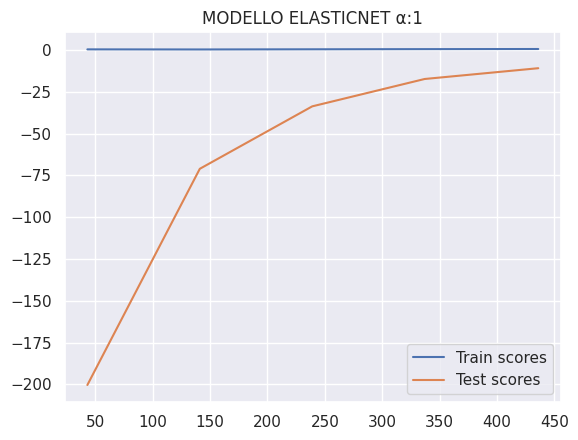

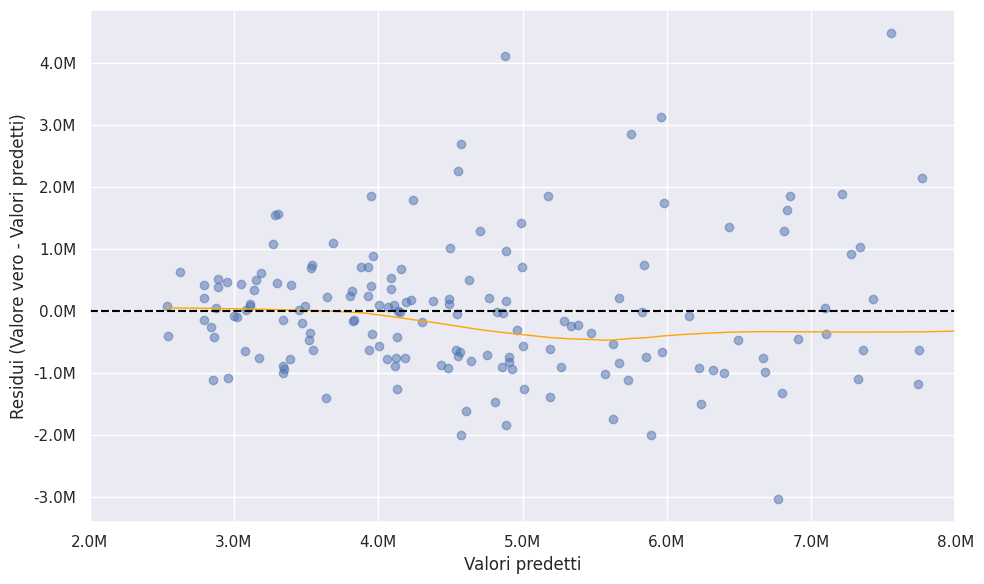

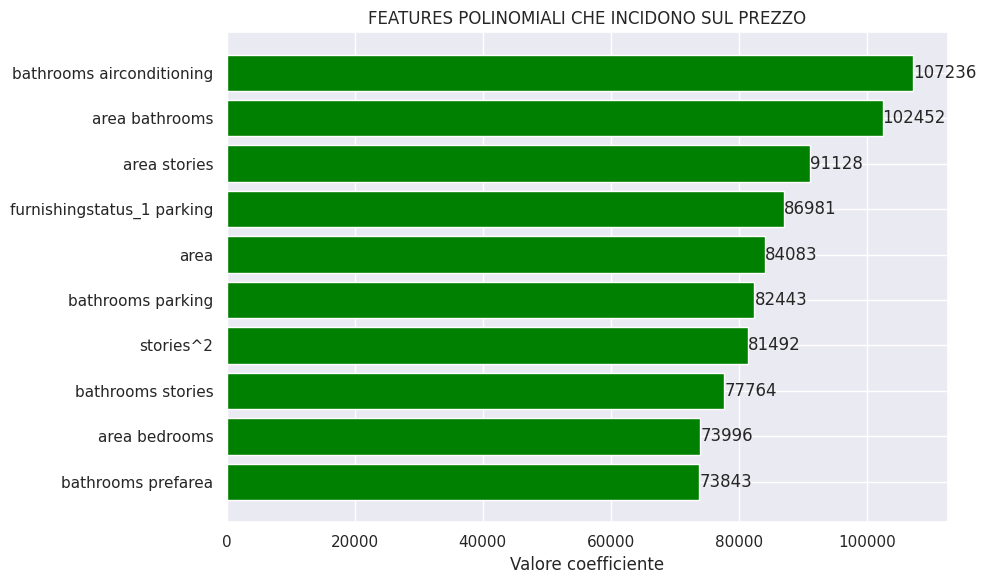

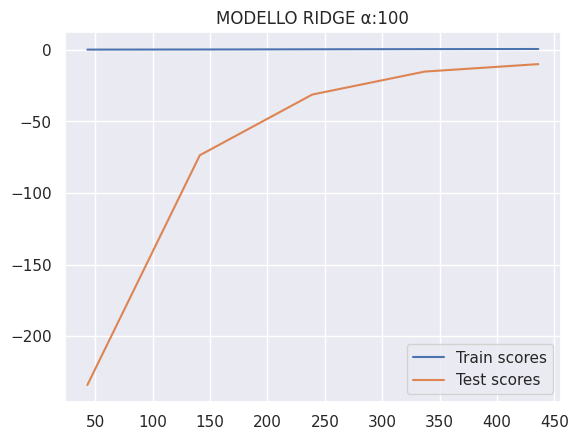

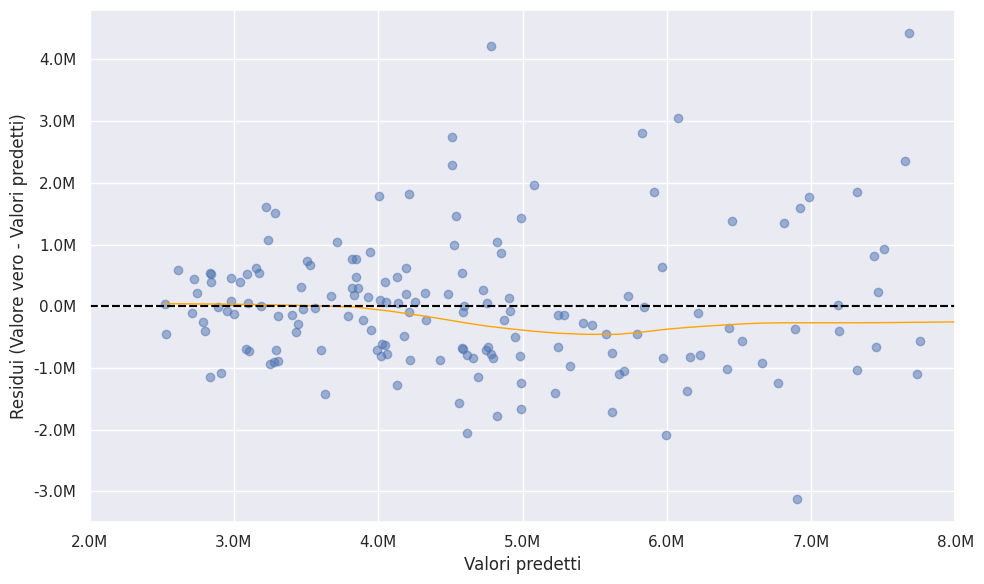

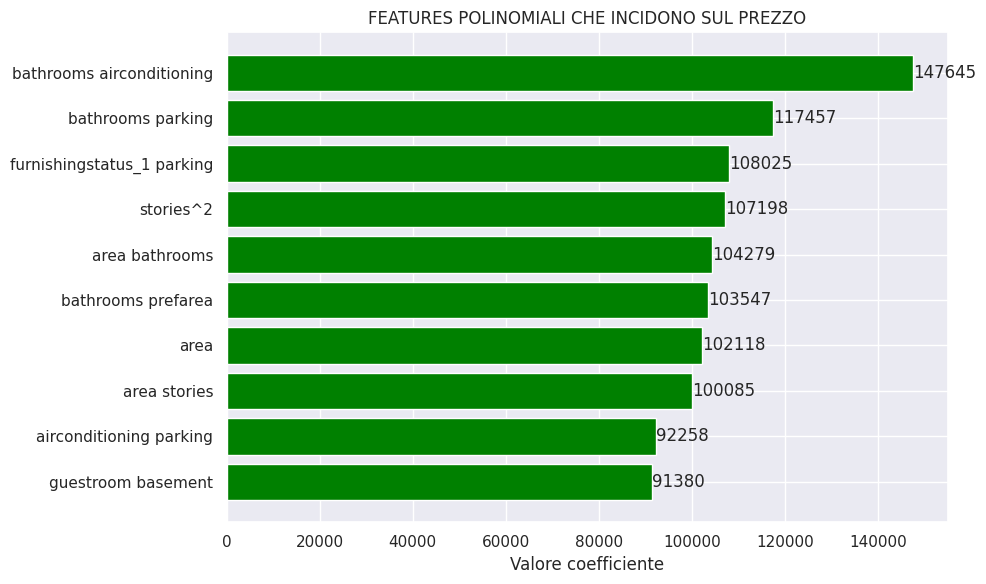

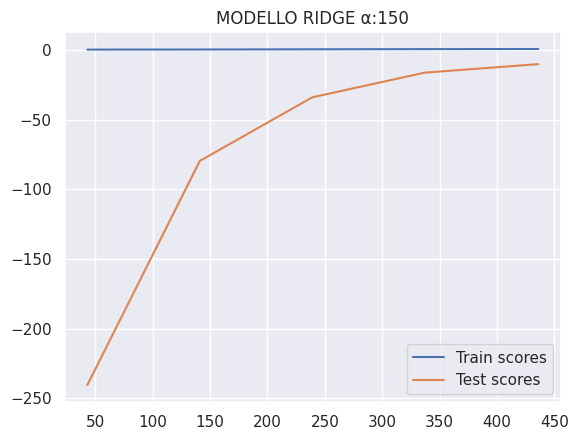

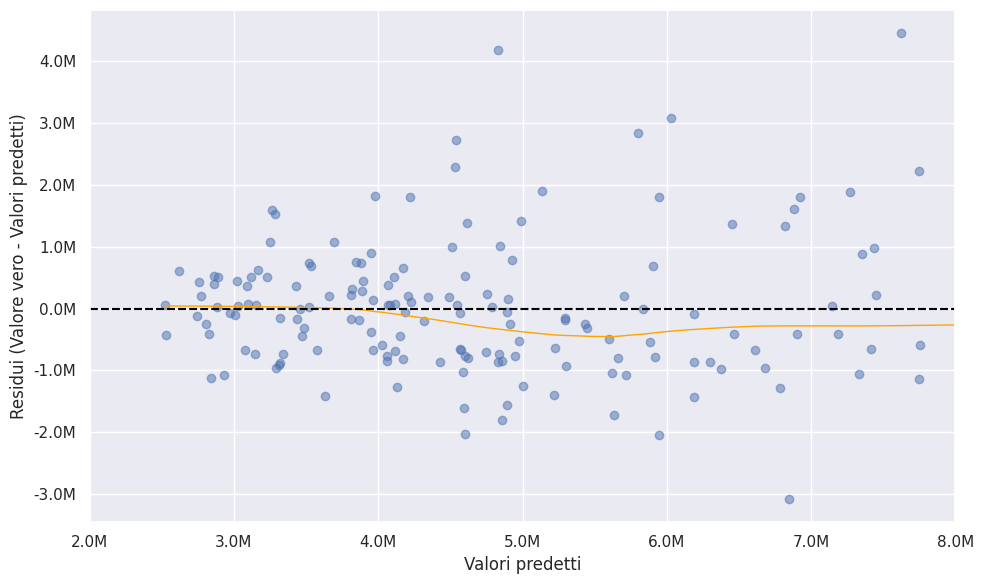

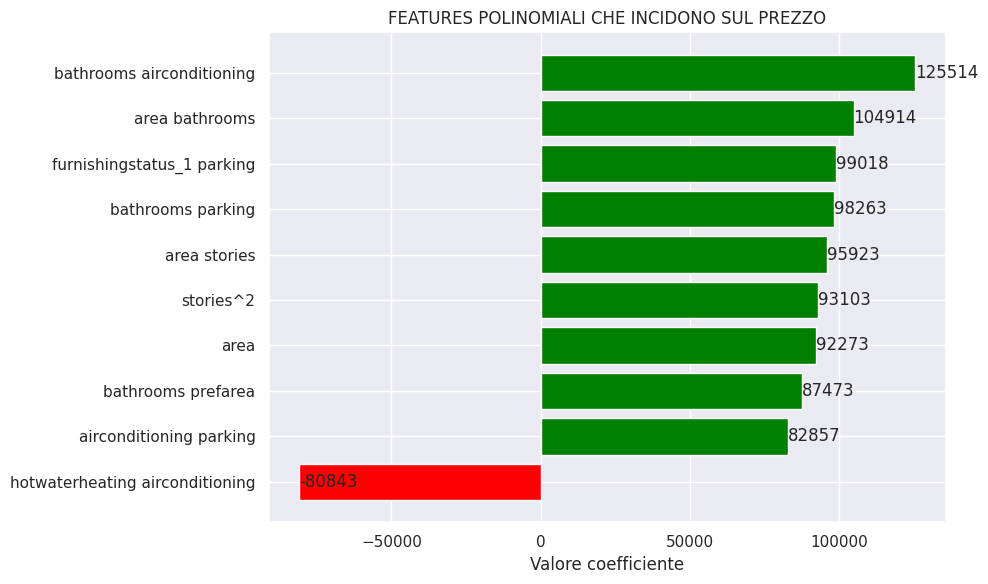

In [ ]:
for m in models:
  title = f"MODELLO {m['name']} α:{m['alpha']}"
  showLearning_curve(title,m['model'],x,y)
  residuals_vs_predicted(m['name'],m['model'],y_test,m['test']['y_pred'])
  plot_top_features(m['importances'],'FEATURES POLINOMIALI CHE INCIDONO SUL PREZZO')
